## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [1]:
!pip install torch torchvision

In [2]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (19/19), 3.30 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Task 2 : Loading VGG Pretrained Model

In [3]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 57.7MB/s]


In [4]:
vgg = vgg.features

In [5]:
for parameter in vgg.parameters():
  parameter.requires_grad_(False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [8]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert("RGB")
  size = min(max_size, max(image.size))

  img_transforms = T.Compose(
      [
          T.Resize(size),
          T.ToTensor(),
          T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]
          )
      ]
  )

  image = img_transforms(image)
  image = image.unsqueeze(0)
  return image

## Task 4 : Deprocess image

In [9]:
content_p = preprocess("/content/Project-NST/spiderman.jpg")
style_p = preprocess("/content/Project-NST/style11.jpg")

content_p = content_p.to(device)
style_p = style_p.to(device)

print(content_p.shape)
print(style_p.shape)

torch.Size([1, 3, 500, 888])
torch.Size([1, 3, 500, 577])


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.detach().numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

  return image

In [11]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print(content_d.shape)
print(style_d.shape)

(500, 888, 3)
(500, 577, 3)


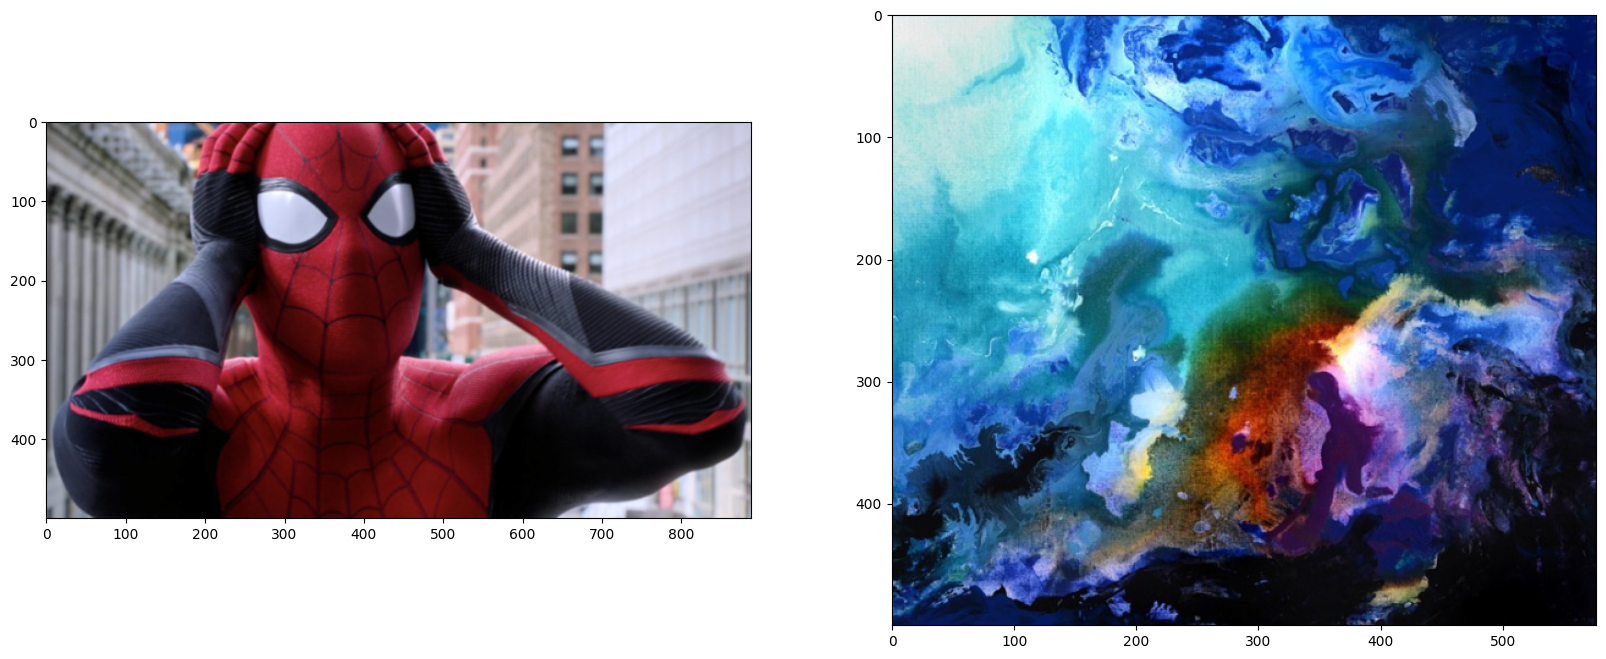

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

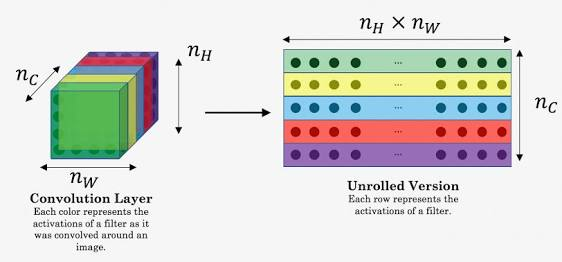

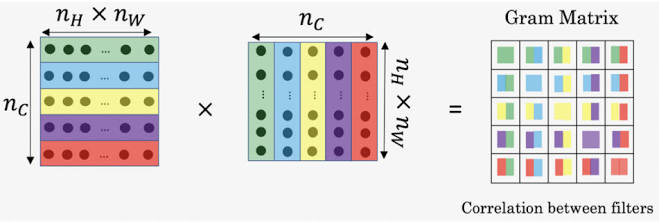

In [13]:
def get_features(image, model):
  layers = {
      "0": "conv1_1",
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2",
      "28": "conv5_1",
  }

  x = image
  Features = {}

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

  return Features

In [14]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

In [15]:
def gram_matrix(tensor):
  b,c,h,w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [16]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [17]:
def content_loss(target_f, content_f):
  loss = torch.mean((target_f - content_f)**2)
  return loss

In [18]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}

In [19]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0

  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss


In [20]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print(f"content loss: {content_loss(target_f['conv4_2'], content_f['conv4_2'])}")
print(f"style loss: {style_loss(style_weights, target_f, style_grams)}")

content loss: 0.0
style loss: 550.8432006835938


## Task 7 : Training loop

In [21]:
from torch import optim

optimizer = optim.Adam([target], lr=0.003)

# content reconstruction rate
alpha = 1
beta = 1e2

epochs = 3000
show_every = 500

In [22]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [23]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)
  t_loss = total_loss(
      content_loss(target_f["conv4_2"], content_f["conv4_2"]),
      style_loss(style_weights, target_f, style_grams),
      alpha,
      beta
  )

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at epoch {i} : {t_loss}")
    results.append(deprocess(target))




Total loss at epoch 0 : 55084.3203125
Total loss at epoch 500 : 1503.2811279296875
Total loss at epoch 1000 : 776.9185791015625
Total loss at epoch 1500 : 525.9569091796875
Total loss at epoch 2000 : 416.827880859375
Total loss at epoch 2500 : 362.4703063964844


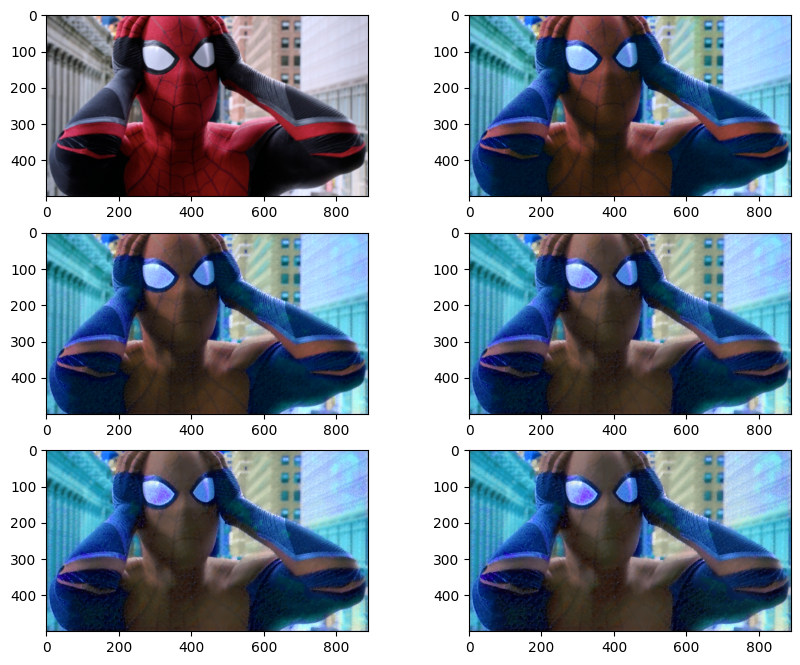

In [24]:
plt.figure(figsize=(10,8))

for i in range(len(results)):
  plt.subplot(3, 2, i+1)
  plt.imshow(results[i])

plt.show()